# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [178]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV


# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [179]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

print("newsgroups length: {}".format(len(newsgroups_test.target)))

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[int(num_test/2):],newsgroups_test.target[int(num_test/2):]
dev_data, dev_labels = newsgroups_test.data[:int(num_test/2)], newsgroups_test.target[:int(num_test/2)]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('test label shape:', test_labels.shape)
print('dev label shape:', dev_labels.shape)
print('labels names:', newsgroups_train.target_names)

newsgroups length: 1353
training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

[2 pts]

In [180]:
def P1(num_examples=5):
### STUDENT START ###
    """Prints a specified number of example douments from newsgroups postings data.

    Args:
        num_examples (int): number of examples to display. Defaults to 5 examples.
        
    Kwargs:
        N/A
        
    Returns:
        N/A
    """
    for ind in range(0,num_examples):
        example_label = newsgroups_train.target_names[train_labels[ind]]
        print("\nExample({}) Label={}, Text:".format(ind+1, example_label))
        print("-------------------------------------------------")
        print(train_data[ind])
        print("-------------------------------------------------")

### STUDENT END ###
P1(5)


Example(1) Label=comp.graphics, Text:
-------------------------------------------------
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
-------------------------------------------------

Example(2) Label=talk.religion.misc, Text:
-------------------------------------------------


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

[6 pts]

In [181]:
def P2():
### STUDENT START ###
    """Explore tokenization/vectorization of text using CountVectorizer, including 
    the shape of the resulting matrices, vocabulary and several vectorization options.
    Printing results for each of such investigation of detail.

    Args:
        N/A
        
    Kwargs:
        N/A
        
    Returns:
        N/A
    """
    
    # Tokenize/vectorize the training data and get the length of the vocabulary and the
    # dimensions of the resulting matrix
    count_vect = CountVectorizer()
    words_dtm = count_vect.fit_transform(train_data)
    vocab = count_vect.get_feature_names()
    unigram_vocab_size = len(vocab)
    data_shape = words_dtm.shape
    total_entries = data_shape[0]*data_shape[1]
    fract_nonempty = words_dtm.nnz/total_entries
    mean_nz_features = words_dtm.nnz/len(train_data)

    print()
    print("\n2a.")
    print("-------------------------------")
    print("Train Feature Matrix({}) (# examples, # words)".format(data_shape))
    print("Train Vocabulary includes {} words.".format(unigram_vocab_size))
    print("Avg # of non-zero features per example: {:.2f}".format(mean_nz_features))
    print("Fraction of non-zero out of full matrix ({}/{}): {:.4f}".format(words_dtm.nnz,
                                                                           total_entries,
                                                                           fract_nonempty))

    print("\n2b.")
    print("-------------------------------")
    print("Train vocabulary 0th word: {}".format(vocab[0]))
    print("Train vocabulary last word: {}".format(vocab[len(vocab)-1]))

    # Again vectorize the documents, this time specifying a very limited vocabulary
    limited_vocab_vect = CountVectorizer(vocabulary= ["atheism", "graphics", 
                                                      "space", "religion"])
    words_dtm = limited_vocab_vect.fit_transform(train_data)

    # Determine the resulting dimensions of the vocabulary, matrix and non-zero features
    vocab = limited_vocab_vect.get_feature_names()
    data_shape = words_dtm.shape
    total_entries = data_shape[0]*data_shape[1]
    fract_nonempty = words_dtm.nnz/total_entries
    mean_nz_features = words_dtm.nnz/len(train_data)
    
    print("\n2c.")
    print("-------------------------------")    
    print("Limited Vocab Feature Matrix({}) (# examples, # words)".format(data_shape))
    print("Train Vocabulary includes {} words.".format(len(vocab)))
    print("Average # of non-zero features per example: {:.4f}".format(mean_nz_features))
    print("Fract non-zero entries out of full matrix ({}/{}): {:.4f}".format(words_dtm.nnz,
                                                                             total_entries,
                                                                             fract_nonempty))
  
    print("\n2d.")
    print("-------------------------------")
    # Extract bigram and trigram features, determining the vocabulary size
    count_vect = CountVectorizer(analyzer='word',ngram_range=(2,3))
    words_dtm = count_vect.fit_transform(train_data)
    
    vocab = count_vect.get_feature_names()
    bitrigram_vocab_size = len(vocab)
    
    print("Size of vocabulary with bigrams and trigrams: {}".format(bitrigram_vocab_size))
    print("Compared to the vocab with just unigrams ({} words),".format(unigram_vocab_size))
    ratio_bt_u = bitrigram_vocab_size/unigram_vocab_size
    print("using bigrams and trigrams produced vocab {:.2f} times larger".format(ratio_bt_u))
    
    print("\n2e.")
    print("-------------------------------")
    just_10df = 10/len(train_data)
    print("Words appearing in 10/{} documents have a df of {:.4f}".format(len(train_data),
                                                                          just_10df))
    # Build a new matrix, ignoring words occuring in fewer than 10 documents
    count_vect = CountVectorizer(min_df=just_10df)
    words_dtm = count_vect.fit_transform(train_data)
    ignored_vocab = count_vect.get_feature_names()
    orig_to_ignored_ratio = unigram_vocab_size / len(ignored_vocab)
    print("Ignoring words with frequency {:.4f} or less gives vocab".format(just_10df))
    print("of {} words, {:.2f} x smaller than unigram vocab".format(len(ignored_vocab),
                                                                    orig_to_ignored_ratio))
    
    print("\n2f.")
    print("-------------------------------")
    # Build a maxtrix from the dev data and get the size of the vocab, along with difference
    # in sizes compared to the training vocab
    dev_count_vect = CountVectorizer()
    dev_words_dtm = dev_count_vect.fit_transform(dev_data)
    dev_vocab = dev_count_vect.get_feature_names()
    missing_per = (unigram_vocab_size-len(dev_vocab))/unigram_vocab_size*100
    print("Vocab observed in dev data includes {} words.".format(len(dev_vocab)))
    print("{:.2f}% of words in train vocab missing from the dev vocab".format(missing_per))

### STUDENT END ###
P2()



2a.
-------------------------------
Train Feature Matrix((2034, 26879)) (# examples, # words)
Train Vocabulary includes 26879 words.
Avg # of non-zero features per example: 96.71
Fraction of non-zero out of full matrix (196700/54671886): 0.0036

2b.
-------------------------------
Train vocabulary 0th word: 00
Train vocabulary last word: zyxel

2c.
-------------------------------
Limited Vocab Feature Matrix((2034, 4)) (# examples, # words)
Train Vocabulary includes 4 words.
Average # of non-zero features per example: 0.2684
Fract non-zero entries out of full matrix (546/8136): 0.0671

2d.
-------------------------------
Size of vocabulary with bigrams and trigrams: 510583
Compared to the vocab with just unigrams (26879 words),
using bigrams and trigrams produced vocab 19.00 times larger

2e.
-------------------------------
Words appearing in 10/2034 documents have a df of 0.0049
Ignoring words with frequency 0.0049 or less gives vocab
of 3064 words, 8.77 x smaller than unigram vocab

(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

[4 pts]

In [182]:
def P3():
### STUDENT START ###
    """Using CountVectorizer for tokenization/vectorization of newsgroups training data,
    determine the F1 score for a default KNeighborsClassifier, then find the optimal value
    of k for this classifier. Fit a MultinomialDB classifier and find the optimal value of
    alpha, as well as fitting a LogisticRegression classifier and find the optimal value for
    regularization strength C using L2 regulariation.

    Args:
        N/A
        
    Kwargs:
        N/A
        
    Returns:
        N/A
    """

    cvect = CountVectorizer()
    train_words_dtm = cvect.fit_transform(train_data)
    dev_words_dtm = cvect.transform(dev_data)

    # Fit the default K-nn classifier with training data
    knn_class = KNeighborsClassifier()
    knn_class.fit(train_words_dtm, train_labels)
    pred = knn_class.predict(dev_words_dtm)

    # Note that 'f1_weighted' results in metrics calculated for each label and then weighted
    # to account for label imbalances in the sample.
    f1_val = metrics.f1_score(dev_labels, pred, average='weighted')
    print("Weighted F1 score for default K-NN (k_n=5): {:.4f}".format(f1_val))
    
    # This boolean enables/disables K-nn classifier analysis, to speed development
    knn = True
    
    if knn:    
        # Maximum n_neighbors value to try will be the square root of the # of samples.
        # This top value was chosen based on common advice to try this value when 
        # optimizing KNN classifiers
        top_k_val = int(np.sqrt(len(train_labels)))
        k_values = list(range(1,top_k_val,2))
        param_grid = dict(clf__n_neighbors=k_values)

        # Create a GridSearchCV pipeline for vectorizing docs and evaluating KNN classifier
        # at different n_neighbors values.
        pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('clf', KNeighborsClassifier()),
        ])
        
        gsCV = GridSearchCV(pipeline, param_grid=param_grid,
                            error_score=0, scoring='f1_weighted')

        print("\nEvaluating KNN clf on words vect with k_n=[1,...,{}]".format(top_k_val))
        print("(please wait...)")
        # Fit the data with the training data
        gsCV.fit(train_data, train_labels)
        dev_score = gsCV.score(dev_data, dev_labels)
    
        print("Best weighted F1 score: {:.4f}".format(gsCV.best_score_))
        print("Best k_n for F1 score: {}".format(gsCV.best_params_['clf__n_neighbors']))
        print("dev data prediction score: {:.4f}\n".format(dev_score))
        
        # End of K-nn analysis
    
    
    # This boolean enables/disables MultinomialDB classifier analysis, to speed development
    mNB = True
        
    if mNB :
        # Setting up params to evaluate multinomial Naive Bayes model:
        alphas = [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]
        alpha_grid = dict(clf__alpha=alphas)

        # Create a GridSearchCV pipeline for evaluating multinomial Naive Bayes
        # at different n_neighbors values.
        pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('clf', MultinomialNB())
        ])
        gsCV = GridSearchCV(pipeline, param_grid=alpha_grid, error_score=0, 
                            scoring='f1_weighted')
    
        print("\nEvaluating multinomial Naive Bayes classify on words vect with")
        print("alpha values : {}]".format(alpha_grid['clf__alpha']))
        print("(please wait...)")
        
        # Fit the data with the training data
        gsCV.fit(train_data, train_labels)
        dev_score = gsCV.score(dev_data, dev_labels)
    
        print("Best weighted F1 score for MultinomialNB: {:.4f}".format(gsCV.best_score_))
        print("Best alpha for F1 score: {}".format(gsCV.best_params_['clf__alpha']))    
        print("dev data prediction score: {:.4f}\n".format(dev_score))
        
        # End of MultinomialNB analysis
        
    # Setup list of C regularization values for use in multiple analyses
    C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    params_grid = dict(clf__C=C_values)

    
    # This boolean enables/disables LR classifier analysis, to speed development
    lr = True
    
    if lr:
        
        # Create a GridSearchCV pipeline for evaluating Logistic Regression
        # at different C values.

        pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('clf', LogisticRegression())
        ])

        gsCV = GridSearchCV(pipeline, param_grid=params_grid, 
                            refit='f1', error_score=0, scoring='f1_weighted')
    
        print("\nEvaluating LogisticRegression on words vect with")
        print("C values : {}".format(params_grid['clf__C']))
        print("(please wait...)")
        
        # Fit the data with the training data
        gsCV.fit(train_data, train_labels)
        dev_score = gsCV.score(dev_data, dev_labels)
    
        print("Best weighted F1 score for LR: {:.4f}".format(gsCV.best_score_))
        print("Best C value for F1 score: {}\n\n".format(gsCV.best_params_['clf__C']))    
        print("dev data prediction score: {:.4f}\n".format(dev_score))
        
        
    # For each C values, fit a LogisticRegression and collect the sum of squared weights

    observations = []
    
    for C_val in C_values:
        
        classifier = LogisticRegression(C=C_val)
        classifier.fit(train_words_dtm, train_labels)
        weights = classifier.coef_[0]
        sum_squared_weights = sum(weight*weight for weight in weights)
        this_obs = []
        this_obs.append(C_val)
        this_obs.append(sum_squared_weights)
        observations.append(this_obs)

    print("Tested C values and observed sums of squared weights:")
    for this_obs in observations:
        print("C value: {:4.4f}  Sum of Squared Weights: {:4.4f}".format(this_obs[0],
                                                                         this_obs[1]))
    
### STUDENT END ###
P3()

Weighted F1 score for default K-NN (k_n=5): 0.4288

Evaluating KNN clf on words vect with k_n=[1,...,45]
(please wait...)
Best weighted F1 score: 0.4162
Best k_n for F1 score: 19
dev data prediction score: 0.4366


Evaluating multinomial Naive Bayes classify on words vect with
alpha values : [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]]
(please wait...)


/Users/burgew/Library/Python/3.6/lib/python/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/burgew/Library/Python/3.6/lib/python/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/burgew/Library/Python/3.6/lib/python/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Best weighted F1 score for MultinomialNB: 0.8296
Best alpha for F1 score: 0.01
dev data prediction score: 0.7752


Evaluating LogisticRegression on words vect with
C values : [0.001, 0.01, 0.1, 1, 10, 100, 1000]
(please wait...)
Best weighted F1 score for LR: 0.7612
Best C value for F1 score: 0.1


dev data prediction score: 0.6966

Tested C values and observed sums of squared weights:
C value: 0.0010  Sum of Squared Weights: 0.1651
C value: 0.0100  Sum of Squared Weights: 2.5415
C value: 0.1000  Sum of Squared Weights: 27.1362
C value: 1.0000  Sum of Squared Weights: 167.0110
C value: 10.0000  Sum of Squared Weights: 586.7537
C value: 100.0000  Sum of Squared Weights: 952.7015
C value: 1000.0000  Sum of Squared Weights: 2714.8716


ANSWER:

a. Why doesn't nearest neighbors work well for this problem?

Given that CountVectorizer generates total counts of each word in each document without normalization based on document lengths, the counts don't represent a reliable word frequency within the English language.  A far better measure would be something that used tf-idf or word similarity.  In addition, words with similar occurence counts don't repesent a high-fidelity relationship cluster, thus reducing the value of nearest neighbors.


b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

There are researchers (Sida Wang and Christopher D. Manning) who have shown that Multinomial Naive Bayes produces better results for short text documents than SVMs or Logistic regression. Interestingly, it is also shown that Multinomial Naive Bayes performs better than SVMs or Logistic regression with small numbers of training examples, while that is not the case in this data, since the smallest number of training examples is 377 for label 3, while the largest number of training examples is 593, for label 2.

c. Briefly explain the relationship between the sum and the value of C.

The C parameter of the LogisticRegression class is applied as $1/\lambda$ for regularization. As such, there is stronger regularization with smaller values of C and weaker regularization with larger values of C. This is demonstrated by the sum of squared weights for each tested C value, which is less than 1 where the small C value has resulted in stronger regularization and almost $3,000$ where the large C value has resulted in weaker regularization. 

This shows that stronger regularization results in smaller absolute magnitude of feature weights and therefore less overfitting to the training data, thus a more generalizable model. Conversely, the larger C values produce less regularization and thus more overfitting with a less generalizable mode.

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

[5 pts]

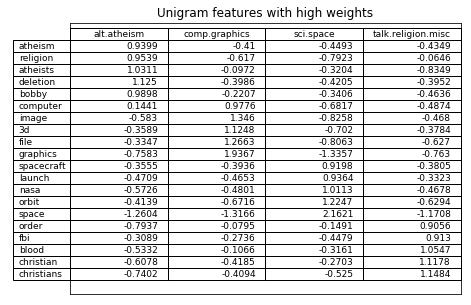

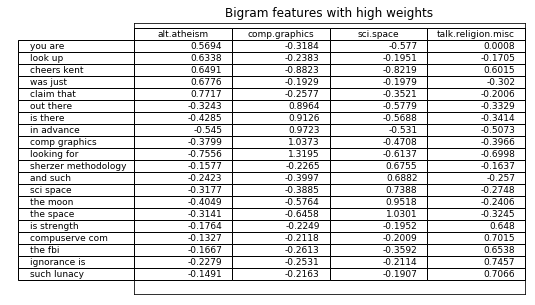

In [183]:
def P4():
### STUDENT START ###
    """Using a LogisticRegression classifier, find 5 features with largest weights per label,
    displaying the data as a table. Then determine and display the same type of results using
    bigram features.

    Args:
        N/A
        
    Kwargs:
        N/A
        
    Returns:
        N/A
    """

    # Create a unigram word counts matrix from train_data and fit an LR classifier
    vect = CountVectorizer()
    words_dtm = vect.fit_transform(train_data)
    clf = LogisticRegression()
    clf.fit(words_dtm, train_labels)
    
    # Grab the weights assigned to each feature, labels for each column and build table
    feature_weights = clf.coef_
    column_labels = newsgroups_train.target_names
    row_labels, class_feature_weights = generate_table_data(feature_weights, 
                                                            vect.get_feature_names())

    # Display a table displaying the collected unigram feature weights
    display_class_feature_weights('Unigram features with high weights',
                                  column_labels,
                                  row_labels, 
                                  class_feature_weights)
    
    # Create a unigram word counts matrix from train_data and fit an LR classifier
    vect = CountVectorizer(analyzer='word',ngram_range=(2,2))
    words_dtm = vect.fit_transform(train_data)
    clf = LogisticRegression()
    clf.fit(words_dtm, train_labels)
    
    # Grab the weights assigned to each feature, labels for each column and build table
    feature_weights = clf.coef_
    column_labels = newsgroups_train.target_names
    row_labels, class_feature_weights = generate_table_data(feature_weights, 
                                                            vect.get_feature_names())

    # Display a table displaying the collected unigram feature weights
    display_class_feature_weights('Bigram features with high weights',
                                  column_labels,
                                  row_labels, 
                                  class_feature_weights)
    
def generate_table_data(feature_weights, feature_names):
    """Generate data for display in feature weights results table.

    Args:
        feature_weights (array_like): Labels and associated lists of feature weights  
        feature_names (array_like): Collection of feature names
        
    Kwargs:
        N/A
        
    Returns:
        row labels (array of str) : Names of observed features for display in table
        class_feature_weights (array of float) : Feature/label weights
    """
    
    max_weighted_features = []
    class_feature_weights = []
    
    # Loop through the feature weights for each label, grabbing the indices of the five 
    # highest and appending the indices to a list to be used to collect weights for across 
    # all 4 class labels
    for label_ind in range(0,4):
        for this_feature in np.argpartition(feature_weights[label_ind], -5)[-5:]:    
            max_weighted_features.append(this_feature)

    row_labels = []
    
    # Collect names of features of interest, for use as row labels, along with feature weights
    # for each feature/label intersection
    for feature in max_weighted_features:
        row_labels.append(feature_names[feature])
        this_feature_weights = []
        
        for class_ind in range(0, feature_weights.shape[0]):
            this_weight = feature_weights[class_ind,feature]
            this_feature_weights.append(round(this_weight,4))
        class_feature_weights.append(this_feature_weights)

    # Round the collected weights to 4 decimals for display
    np.round(class_feature_weights,4)
    
    return row_labels, class_feature_weights
    
    
def display_class_feature_weights(title, column_labels, row_labels, cell_values):
    """Display feature weights results table

    Args:
        title (str): Title to display above table
        column_labels (list of str): Labels to display above each column
        row_labels (list of str): Labels to display left of each row
        cell_values (str): Values for display in cells
        
    Kwargs:
        N/A
        
    Returns:
        N/A
    """

    # Setup a plot figure, assign title and clear the tick marks
    fig = plt.figure(figsize=(7,5),frameon=False)
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    
    # Display the table with the input data, using a reasonable font size
    the_table = plt.table(cellText=cell_values,
                         colLabels=column_labels,
                         rowLabels=row_labels,
                         fontsize=20,
                         loc='upper center')
    plt.show()
    
### STUDENT END ###
P4()

ANSWER:  It certainly makes sense that bigram features such as "comp graphics" is strongly weighted for label "comp.graphics". However, "looking for" is also weighted strongly for the same label, and this weight would seem to inappropriately associate documents with this label that may not be at all related. Another such feature, also heavily weighted for comp.graphics, is "is there". This type of feature attribution will produce classification errors.

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

[4 pts]

In [185]:
def empty_preprocessor(s):
    return s

def better_preprocessor(s):
### STUDENT START ###
    """Text preprocessor for use by a machine learning estimator such as those provided in
    the sklearn package. This class applies text preprocessing to optimize text classification
    for a CountVectorizer.

    Args:
        s (str): a raw text string to be prepared for tokenization/vectorization.
        
    Kwargs:
        N/A
        
    Returns:
        (str): preprocessed value for further processing/estimation
    """

    # Replace all e-mail addresses with a token
    email_pattern = '[^@|\s]+@[^@]+\.[^@|\s]+'
    s = re.sub(email_pattern,'email',s)
    
    # Replace real numbers with a token
    s = re.sub('[0-9]+\.[0-9]+', 'real_number',s)
    
    # Replace all years since the 18th century with appropriate tokens per century
    s = re.sub('20[0-2][0-9]', '21rst_cent_year',s)
    s = re.sub('19[0-9][0-9]', '20th_cent_year',s)
    s = re.sub('18[0-9][0-9]', '19th_cent_year',s)
    s = re.sub('17[0-9][0-9]', '18th_cent_year',s)
    
    # Remove all hashtags
    s = re.sub('#[a-zA-Z]+', ' ', s)

    # Remove all URLs
    pattern = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    s = re.sub(pattern,' ',s)
    
    # Replace remaining sequences of digits
    s = re.sub('[0-9]+', digit_repl, s)
        
    # Now cleanup, replace all those sequences of multiple spaces with single spaces
    s = re.sub('\s+', ' ',s)

    s = s.lower()

    return s

# This function will replace digit sequences with the digit count followed by '-digits'
def digit_repl(matchobj):
    """Parse an input string containing a sequence of digits, returning a string
    representation that includes the number of digits.

    Args:
        matchobj (str): a string containing a sequence of digits, passed by the re.sub
        function for replacement
        
    Kwargs:
        N/A
        
    Returns:
        str: "<num_digits-digits>" where num_digits is the number of characters in the input string
    """

    digits_str = matchobj.group(0)
    return '<'+str(len(digits_str))+'-digits>'

### STUDENT END ###

def P5():
### STUDENT START ###
    """Using CountVectorizer, fit a LogisticRegression classifier with newsgroups trianing
    data, determining F1 score. Then, using a preprocessor for the CountVectorizer, again
    fit the LogisticRegression classifier and determine the improvement in F1 score.

    Args:
        N/A
        
    Kwargs:
        N/A
        
    Returns:
        N/A
    """


    # Setup the default case - no preprocessing of text
    # Build matrix of token counts using the default CountVectorizer, for train and dev data
    vect = CountVectorizer()
    default_train_dtm = vect.fit_transform(train_data)
    default_dev_dtm = vect.transform(dev_data)
    print("default_train_dtm : {}".format(default_train_dtm.shape))
    print("default_dev_dtm : {}".format(default_dev_dtm.shape))
    vocab = vect.get_feature_names()
    print("Words vector vocab of size {} without preprocessing ".format(len(vocab)))
    
    # Fit a LogisticRegression classifier with train data, generate prediction from dev data,
    # and report on the F1 score.
    clf = LogisticRegression()
    clf.fit(default_train_dtm, train_labels)
    pred = clf.predict(default_dev_dtm)
    unopt_f1_val = metrics.f1_score(dev_labels, pred, average='weighted')
    print("F1 score of LR with default vectorization: {:.2f}".format(unopt_f1_val))

    # Setup the optimized case, with preprocessing of text
    # Build test/dev matrices of token counts supplyin a preprocessor to CountVectorizer
    vect = CountVectorizer(preprocessor=better_preprocessor)
    opt_train_dtm = vect.fit_transform(train_data)
    opt_dev_dtm = vect.transform(dev_data)
    print("train_words_dtm : {}".format(opt_train_dtm.shape))
    opt_vocab = vect.get_feature_names()
    print("Words vector vocabulary of size {} after preprocessing ".format(len(opt_vocab)))

    # Fit a LogisticRegression classifier with train data, generate prediction from dev data,
    # and report on the F1 score.
    clf = LogisticRegression()
    clf.fit(opt_train_dtm, train_labels)
    print("opt_dev_words_dtm : {}".format(opt_dev_dtm.shape))
    pred = clf.predict(opt_dev_dtm)
    opt_f1_val = metrics.f1_score(dev_labels, pred, average='weighted')
    print("F1 score of LR with optimized vectorization: {:.2f}".format(opt_f1_val))

    # Calculate and print the optimization result with preprocessing
    improvement = 100*(opt_f1_val-unopt_f1_val)
    print("\nNote that this result is {:.2f}% better than without preprocessing.\n".format(improvement))
### STUDENT END ###
P5()

default_train_dtm : (2034, 26879)
default_dev_dtm : (676, 26879)
Words vector vocab of size 26879 without preprocessing 
F1 score of LR with default vectorization: 0.69
train_words_dtm : (2034, 21246)
Words vector vocabulary of size 21246 after preprocessing 
opt_dev_words_dtm : (676, 21246)
F1 score of LR with optimized vectorization: 0.71

Note that this result is 2.02% better than without preprocessing.



(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

[4 pts]


train_words_dtm : (2034, 26879)
dev_words_dtm : (676, 26879)
Words vector vocab of size 26879

Minimum feature weight magnitude with L1 reg: 0.0
With L1 reg, learned 1061 features with non-zero weights.
L1 regularization produced accuracy 0.6982 accuracy.


Minimum feature weight magnitude with L2 reg: 0.00000005
With L2 reg, learned 26879 features (all features) with non-zero weights.
L2 regularization produced accuracy 0.6967 accuracy.


Pruned vocab size=26577, keeping non-zero feature weights.
Retrained LR with a pruned vocab gave 0.7027 accuracy.




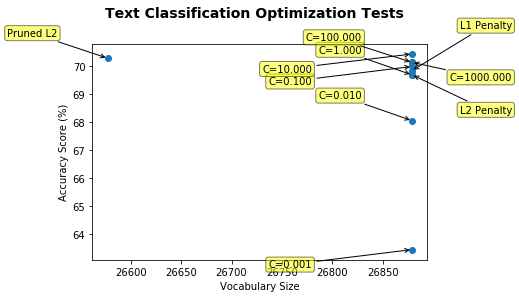

In [186]:
def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    ### STUDENT START ###
    """Evaluate the accuracy of the LogisticRegression classifier using L1 and L2 penalty
    and various values for the C regularization strength parameter. Display a plot capturing
    these results.

    Args:
        N/A
        
    Kwargs:
        N/A
        
    Returns:
        N/A
    """

    
    # These lists will be used for collection of plot data and labels
    plot_data = []
    plot_labels = []
    
    # Use a CountVectorizer to build token count matrices for train and dev data
    default_vect = CountVectorizer()
    train_words_dtm = default_vect.fit_transform(train_data)
    print("\ntrain_words_dtm : {}".format(train_words_dtm.shape))
    dev_words_dtm = default_vect.transform(dev_data)
    print("dev_words_dtm : {}".format(dev_words_dtm.shape))
    orig_vocab = default_vect.get_feature_names()
    orig_size = len(orig_vocab)
    print("Words vector vocab of size {}".format(orig_size))
    
    # Fit a LogisticRegression classifier using L1 penalty, report on accuracy
    clf = LogisticRegression(penalty='l1', tol=.01)
    clf.fit(train_words_dtm, train_labels)
    l1_accuracy = clf.score(dev_words_dtm,dev_labels)
    l1_feature_weights = clf.coef_
    weights_per_feature = np.rot90(l1_feature_weights)
    min_mag = min(min(abs(fws)) for fws in weights_per_feature)
    l1_nonzero_count = sum([1 for feature in weights_per_feature if sum(abs(feature))>0.0])
    
    print("\nMinimum feature weight magnitude with L1 reg: {}".format(min_mag))
    print("With L1 reg, learned {} features with non-zero weights.".format(l1_nonzero_count))
    print("L1 regularization produced accuracy {:.4f} accuracy.\n".format(l1_accuracy))
    
    # Add the summary result to a set of saved plot data for later display
    plot_data.append([orig_size,l1_accuracy*100])
    plot_labels.append('L1 Penalty')

    # Fit a LogisticRegression classifier using L2 penalty, report on accuracy
    clf = LogisticRegression(penalty='l2', tol=.01)
    clf.fit(train_words_dtm, train_labels)
    l2_accuracy = clf.score(dev_words_dtm,dev_labels)
    l2_feature_weights = clf.coef_
    weights_per_feature = np.rot90(l2_feature_weights)
    min_mag = min(min(abs(fws)) for fws in weights_per_feature)
    l2_nonzero_count = sum([1 for feature in weights_per_feature if sum(abs(feature))>0])
    
    print("\nMinimum feature weight magnitude with L2 reg: {:.8f}".format(min_mag))
    print("With L2 reg, learned {} features (all features) with non-zero weights.".format(l2_nonzero_count))
    print("L2 regularization produced accuracy {:.4f} accuracy.\n".format(l2_accuracy))
    
    # Add the summary result to a set of saved plot data for later display
    plot_data.append([orig_size,l2_accuracy*100])
    plot_labels.append('L2 Penalty')

    # Collect a pruned vocabulary from list of features with non-zero weights
    pruned_vocab = []
    for this_feature_weights in l2_feature_weights:        
        for feature_ind in range(0,len(this_feature_weights)):
            if this_feature_weights[feature_ind]>0:
                pruned_vocab.append(orig_vocab[feature_ind])
    
    # Remove duplicates from the collected pruned vocabulary
    pruned_vocab = list(dict.fromkeys(pruned_vocab))
    pruned_size = len(pruned_vocab)
    
    print("\nPruned vocab size={}, keeping non-zero feature weights.".format(pruned_size))

    # Generate new counts vector matrices using the pruned vocabulary
    pruned_vect = CountVectorizer(vocabulary=pruned_vocab)
    pruned_train_dtm = pruned_vect.fit_transform(train_data)
    pruned_dev_dtm = pruned_vect.transform(dev_data)

    # Fit a LogisticRegression classifier using L2 penalty (this is the default) with the
    # counts vector for the pruned vocabulary.
    clf = LogisticRegression(penalty='l2', tol=.01)
    clf.fit(pruned_train_dtm, train_labels)
    pr_retr_acc = clf.score(pruned_dev_dtm,dev_labels)
    print("Retrained LR with a pruned vocab gave {:.4f} accuracy.\n\n".format(pr_retr_acc))
    
    # Add the summary result to a set of saved plot data for later display    
    plot_data.append([pruned_size,pr_retr_acc*100])
    plot_labels.append('Pruned L2')
    
    # For each C values, fit a LogisticRegression and collect the accuracies
    C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    for C_val in C_values:
        clf = LogisticRegression(C=C_val, tol=.01)
        clf.fit(train_words_dtm, train_labels)
        this_C_acc = clf.score(dev_words_dtm,dev_labels)
        plot_data.append([orig_size,this_C_acc*100])
        plot_labels.append("C={:4.3f}".format(C_val))
    
    plot_data = np.array(plot_data)

    # Create a plot figure and subplot, adusting the positioning and setting x and y labels
    fig = plt.figure()
    fig.suptitle('Text Classification Optimization Tests', fontsize=14, fontweight='bold')
    ax = fig.add_subplot(111)
    fig.subplots_adjust(top=0.85)
    ax.set_xlabel('Vocabulary Size')
    ax.set_ylabel('Accuracy Score (%)')
    
    # Plot the collected data, using the Spectral color map
    plt.subplots_adjust(bottom = 0.1)
    plt.scatter(plot_data[:,0], plot_data[:,1],
                marker='o',
                cmap=plt.get_cmap('Spectral'))

    # The following coordinates, move and shift variables are set based on trial-and-error
    # tuning of the label positions within the plot. This was done to address the issue
    # of overlapping labels. It is because of this trial-and-error that the first three
    # point labels are displayed in one orientation, the next five in another and the rest
    # in a third.
    
    # These settings will be used for attaching labels to the first three points in the plot
    points = 1
    
    # These values will no additional shifting of labels on the x axis
    x_shift=0   
    x_move=0
    
    # This value will cause the label to be displayed above/below each alternate point
    y_sign=-1
    
    # These values determine the X, Y magnitude of the label displacement
    x_disp=100
    y_disp=40
    
    for label, x, y in zip(plot_labels, plot_data[:,0], plot_data[:,1]):

        # Alternate labels above and below each point
        y_sign = -y_sign
        
        # These settings will be used to attach labels for the next 5 points in a different
        # orientation from the first three points.
        if points > 2:
            
            # The starting X axis displacement for these points before shift is applied
            x_disp=-100

            # Shift the label to the left or right for alternate points
            x_shift=1-x_shift
            x_move=50

            # Flip labels above/below for alternate points
            y_disp=20
        
        # Finally, the remaining point labels will again be shifted away from those before.
        # These complex settings are used to accommodate a small plot space and labels that
        # would otherwise overlap and obscure one another.
        
        if points > 9:
            # Default X displacement (positive=right side) of label
            x_disp=100
        
        # Apply labels to the plot indicating L1, L2 and Pruned L2 as well as C values tested
        this_label = plt.annotate(label,
                                  xy=(x, y), xytext=(x_disp+(x_move*x_shift), 
                                                     y_disp*y_sign),
                                  textcoords='offset points', ha='right', va='bottom',
                                  bbox=dict(boxstyle='round,pad=0.25', 
                                            fc='yellow', 
                                            alpha=0.5),
                                  arrowprops=dict(arrowstyle = '->', 
                                                  connectionstyle='arc3,rad=0'),
                                  fontsize=10)
        
        # This keeps track of the point# to enable displaying the L1/L2 labels differently
        points+= 1

    plt.show()
    
    ### STUDENT END ###
P6()

ANSWER:
    l1 and l2 penalties, along with C regularization strength provide a set of controls for accuracy of results vs.
    overfitting. The combination of a pruned vocabulary with l2 penalty produced the best accuracy, while the l1
    penalty applied fewer non-zero feature weights and the l2 penalty with the original vocabulary delivered lower
    accuracy. C regularization strength is a control with a wide range of resulting accuracy scores. It would be
    interesting to do more investigation of this control and the results it produces.  

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

[4 pts]

In [188]:
def P7():
    ### STUDENT START ###
    """Using a TfidfVectorizer to build a word tokens vector, fit a LogisticRegression
    classifier and display 3 documents with the greatest ratio between the maximum predicted
    probability associated with a label and the predicted probability of the correct label.
    Note that when this ratio is greater than one it indicates an error in classification.

    Args:
        N/A
        
    Kwargs:
        N/A
        
    Returns:
        N/A
    """

    # Use a TfidfVectorizer to build the words counts matrix
    # In contrast to the CountVectorizer, this class supports stripping accents and stop words
    tfidf_vect = TfidfVectorizer(analyzer='word',strip_accents=ascii,stop_words='english', max_df=0.25,
                                 preprocessor=better_preprocessor)
    train_idf_dtm = tfidf_vect.fit_transform(train_data)
    features = tfidf_vect.get_feature_names()
    dev_idf_dtm = tfidf_vect.transform(dev_data)
    
    # As specified in the instructions, setting C to 100 for this LogisticRegression instance.
    lr_class = LogisticRegression(C=100)
    lr_class.fit(train_idf_dtm, train_labels)
    pred = lr_class.predict(dev_idf_dtm) 
    pred_proba = lr_class.predict_proba(dev_idf_dtm)
    feature_weights = lr_class.coef_
    
    # 
    mistakes = []
    classes = newsgroups_train.target_names
    
    for ind in range(0,len(pred_proba)):
        probs = pred_proba[ind]
        corr_label_ind = dev_labels[ind]
        corr_pred = probs[corr_label_ind]
        pred_label_ind = pred[ind]
        
        
        # Find the maximum predicted probability and the associated class index 
        max_pred = max(probs)
        options = np.where(probs==max_pred)
        
        # If more than one label is returned with that maximum proability,
        # select the first that is not the correct label.
        if (len(options)>1):
            mist_options = np.where(options!=corr_label_ind)[0]
            max_pred_ind = mist_options[0]
        else:
            max_pred_ind = options[0]
            
        R = max_pred / corr_pred
                    
        if max_pred_ind != corr_label_ind:
            R_entry = [int(R),ind,pred_label_ind,corr_label_ind]
            mistakes.append(R_entry)
            
    print("Number of mistakes = {}".format(len(mistakes)))
    mistakes = np.array(mistakes)
    mistakes = np.sort(mistakes, axis=0)

    reported_mistakes = 0
    
    # Having sorted the mistakes by R ascending, loop through offsets from the end,
    # Displaying the worst mistakes.
    for endoff in range(0,len(mistakes)):
        mist_ind = len(mistakes)-1-endoff
        
        this_mistake = mistakes[mist_ind]
        
        this_R = this_mistake[0]
        corr_label_ind = int(this_mistake[3])
        pred_label_ind = int(this_mistake[2])
        

        predicted_lab = classes[pred_label_ind]
        correct_lab = classes[corr_label_ind]
        
        if correct_lab != predicted_lab:
            print("\nCorrect was {}, but {} was predicted (R={}).".format(correct_lab,
                                                                        predicted_lab,
                                                                        this_R))
            
            print("Example misclassified document:")
            print("--------------------------------------------")
            print(dev_data[endoff])
            
            print("--------------------------------------------\n")
            reported_mistakes += 1
            if reported_mistakes == 3:
                break


    ### STUDENT END ###
P7()

Number of mistakes = 152

Correct was talk.religion.misc, but sci.space was predicted (R=8).
Example misclassified document:
--------------------------------------------




It sure did!


I have; and all the above teach me that accurately perceiving reality 
is a tricky business -- _not_ that there's no reality.

--
Mark Pundurs
--------------------------------------------


Correct was talk.religion.misc, but sci.space was predicted (R=8).
Example misclassified document:
--------------------------------------------


Hmm...are you a Taoist?  Imposing limits *does* do something useful...it gives
you something to go beyond.


I tend to be a bit critical of any stratification of Taoism.  I especially
tend to frown on any suggestion that "orthodoxy" or "classics" have any
special place in Tao.


So rather than debate what "Taoism *REALLY* means" you are suggesting that
we take someone else's word for it and work thusly?  I'd rather not, thank
you.


Whereas you, of course, have a clear i

ANSWER:

One key issue is that there are a lot of words being attributed to label sci.space that are not specific to that label. 

One way of addressing this might be by decreasing the max_df parameter in TfidfVectorizer so that the tokenizer would filter out more common words.

Also, these erroneously attributed words includes a wealth of words in English that should be treated as stop words. So, one approach to addressing this issue would be using a very large set of stop words in TfidfVectorizer. I have already used the parameter "stop_words='english'", but it is assumed that this list of stop words isn't as complete as it could be.

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

- [1 pt] for a reasonable attempt
- [2 pts] for improved performance

In [189]:
def P8():
    
    ### STUDENT START ###
    
    
    """Using the same basic context an requirements as in P7(), evaluate available options
    for optimization of results and fewer classification errors

    Args:
        N/A
        
    Kwargs:
        N/A
        
    Returns:
        N/A
    """
    
    ########## Exercising vectorizer and classifier with GridSearchCV
    # Note the below boolean (gs) is set to False for the evaluation run of this classification,
    # and as such the below cross-validation look for parameter evaluation/optimization is skipped.
    # If this boolean is set to True, the parameter evaluation/optimization will be performed and the
    # evaluation of the classification will be performed.
    #
    # This value is set to True only for development/optimization and False for showing the results.
    ###########
    
    gs = False
    
    if (gs):
        # Create a GridSearchCV pipeline for Tfidf vectorizing and evaluating LR classifier
        # at different param values.
        pipeline = Pipeline([
        ('vect', TfidfVectorizer(analyzer='word',strip_accents='ascii',
                                 stop_words={'english'},
                                 ngram_range=(1, 1), preprocessor=better_preprocessor)),
        ('clf', LogisticRegression(penalty='l2', C=100,
                                   random_state=1066)),
        ])
       
        # These are the parameters and options being optimized
        parameters = {
        #               'vect__max_df': (0.2, 0.4, 0.6, 0.8, 1)
        #              'vect__min_df': (0.2, 0.4, 0.6, 0.8, 1),
        #              'vect__sublinear_tf': (True,False)
        #              'clf__max_iter': (90,100,110)
        #               'vect__strip_accents': ('ascii',None),
        #              'vect__min_df': (1,5,10,50,100),
        #              'vect__max_df': (.001,.005,.01,.1,.25,.5,.75,.9,1)
        #               'vect__ngram_range': (1, 1),
        #              'clf__solver': ('newton-cg', 'liblinear', 'lbfgs', 'sag', 'saga'),
        #               'clf__C': (0.001,0.01,.01,1,10,100)
                 }
    
        # Create a GridSearchCV with the above defined pipeline
        gsCV = GridSearchCV(pipeline, param_grid=parameters,
                            error_score=0, scoring='f1_weighted')

        print("\nEvaluating LR clf on tfidf words vect")
        print("(please wait...)")
        # Fit the data with the training data
        gsCV.fit(train_data, train_labels)
        test_score = gsCV.score(dev_data, dev_labels)
    
        print("Best weighted F1 score: {:.4f}".format(gsCV.best_score_))
        print("Best params for score: {}".format(gsCV.best_params_))
        print("dev data prediction score: {}\n".format(test_score))
    
        return

    
    # Create a TfidfVectorizer with max_df set lower
    tfidf_vect = TfidfVectorizer(stop_words={'english'},max_df=0.1,preprocessor=way_better_preprocessor,
                                 ngram_range=(1,1))
    
    # Setup word count matrices for train and test datasets 
    train_idf_dtm = tfidf_vect.fit_transform(train_data)
    test_idf_dtm = tfidf_vect.transform(test_data)

    # Save the resulting vocabulary for later comparison, if needed
    orig_vocab = tfidf_vect.get_feature_names()

    # Fit a classifier 
    lr_class = LogisticRegression(C=100, penalty='l2', max_iter=100, solver='saga')
    lr_class.fit(train_idf_dtm, train_labels)

    # Determine the accuracy score with for this classifier
    l2_accuracy = lr_class.score(test_idf_dtm, test_labels)
    
    # Find the number of features with an associated non-zero feature weight
    l2_feature_weights = lr_class.coef_
    weights_per_feature = np.rot90(l2_feature_weights)
    min_mag = min(min(abs(fws)) for fws in weights_per_feature)
    l2_nonzero_count = sum([1 for feature in weights_per_feature if sum(abs(feature))>0])

    # Collect a pruned vocabulary from list of features with non-zero weights
    pruned_vocab = []
    for this_feature_weights in l2_feature_weights:        
        for feature_ind in range(0,len(this_feature_weights)):
            if this_feature_weights[feature_ind]>0:
                pruned_vocab.append(orig_vocab[feature_ind])
    
    # Remove duplicates from the collected pruned vocabulary
    pruned_vocab = list(dict.fromkeys(pruned_vocab))
    pruned_size = len(pruned_vocab)
    
    print("\nPruned vocab size={}, keeping non-zero feature weights.".format(pruned_size))

    # Generate new counts vector matrices using the pruned vocabulary
    tfidf_vect = TfidfVectorizer(vocabulary=pruned_vocab,stop_words='english',max_df=0.1,
                                    preprocessor=better_preprocessor,ngram_range=(1,1))
    train_idf_dtm = tfidf_vect.fit_transform(train_data)
    test_idf_dtm = tfidf_vect.transform(test_data)
    
    # Fit a new classifier
    lr_class = LogisticRegression(C=100, penalty='l2', max_iter=100, solver='saga')
    lr_class.fit(train_idf_dtm, train_labels)
    
    # Generate prediction using the test matrix
    pred = lr_class.predict(test_idf_dtm) 
    pred_proba = lr_class.predict_proba(test_idf_dtm)
    feature_weights = lr_class.coef_
    
    # These will collect the observed mistakes for display afterward
    mistakes = []
    classes = newsgroups_train.target_names
    
    # Look through all the prediction probabilities, calculating R for each and saving values for later display
    for ind in range(0,len(pred_proba)):
        probs = pred_proba[ind]
        
        pred_label_ind = pred[ind]
        corr_label_ind = test_labels[ind]
        corr_pred = probs[corr_label_ind]

        
        # Find the maximum predicted probability and the associated class index
        max_pred = max(probs)

        options = np.where(probs==max_pred)
        options = options[0]
        
        # If there are more than one classes returned with that proability,
        # select the first that is not the correct label.
        if (len(options)>1):
            mist_options = np.where(options!=corr_label_ind)[0]
            max_pred_ind = mist_options[0]
        else:
            max_pred_ind = options[0]

        R = max_pred / corr_pred
        
        if R != 1:
            R_entry = [int(R),ind,pred_label_ind,corr_label_ind]
            mistakes.append(R_entry)
            
    print("Number of mistakes = {}".format(len(mistakes)))
    
    # Sort the mistakes in reverse order by R
    # This is to setup iteration over the mistakes with the highest R value first
    mistakes = np.array(mistakes)
    mistakes = np.sort(-mistakes, axis=0)

    reported_mistakes = 0
    
    # Having sorted the mistakes by R ascending, loop through offsets from the end
    # The negative sign applied to mistakes reverses the sign applied for sorting,
    # so that R values are again positive.
    
    for ind, mistake in list(enumerate(-mistakes)):
        
        R = mistake[0]
        correct_label = classes[mistake[3]]
        predicted_label = classes[mistake[2]]

        if correct_label != predicted_label:
            print("\n\nMistake: {}".format(mistake))
            print("Correct was {}, but {} was predicted (R={}):\n".format(correct_label,
                                                                        predicted_label,
                                                                        mistake[0]))
            
            print("Example misclassified document:")
            print("\n-------------------------------------------------")
            print(test_data[ind])
            print("\n-------------------------------------------------")

            reported_mistakes += 1
            if reported_mistakes == 3:
                break

def way_better_preprocessor(s):
    """Text preprocessor for use by a machine learning estimator such as those provided in
    the sklearn package. This class applies text preprocessing to optimize text classification
    for a CountVectorizer.

    Args:
        s (str): a raw text string to be prepared for tokenization/vectorization.
        
    Kwargs:
        N/A
        
    Returns:
        (str): preprocessed value for further processing/estimation
    """

    # Replace all e-mail addresses with a token
    email_pattern = '[^@|\s]+@[^@]+\.[^@|\s]+'
    s = re.sub(email_pattern,'email',s)
    
    # Replace real numbers with a token
    s = re.sub('[0-9]+\.[0-9]+', 'real_number',s)
    
    # Replace all years since the 18th century with appropriate tokens per century
    s = re.sub('20[0-2][0-9]', '21rst_cent_year',s)
    s = re.sub('19[0-9][0-9]', '20th_cent_year',s)
    s = re.sub('18[0-9][0-9]', '19th_cent_year',s)
    s = re.sub('17[0-9][0-9]', '18th_cent_year',s)
    
    # Remove all hashtags
    s = re.sub('#[a-zA-Z]+', ' ', s)

    # Remove all URLs
    pattern = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    s = re.sub(pattern,' ',s)
    
    # Replace remaining sequences of digits
    s = re.sub('[0-9]+', digit_repl, s)

    # Now cleanup, replace all those sequences of multiple spaces with single spaces
    s = re.sub('\s+', ' ',s)

    s = s.lower()

    return s
    

    ### STUDENT END ###
P8()

/Users/burgew/Library/Python/3.6/lib/python/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



Pruned vocab size=21096, keeping non-zero feature weights.
Number of mistakes = 145


Mistake: [  8 533   2   3]
Correct was talk.religion.misc, but sci.space was predicted (R=8):

Example misclassified document:

-------------------------------------------------

   I was wondering if anyone knows of a graphics package for the PC that
   will do compositing of a series of pictures?

   What I mean by "compositing" is, say I have a live video clip
   (digitized) panning around a living room, and a computer-generated
   bird flying around the screen.  I want to combine these two series of
   pictures so that everywhere where the bird frames are black, I want
   the living room picture to show through.  Yes, I realize I can do this
   with a genlock, and I do own a genlock, but I want to be able to do
   manual compositing also.  It's ok if I have to composite one frame at
   a time; I assumed I'd have to do that anyway.  But being able to
   composite a series of frames would be even b

ANSWER:

Note that the max_df optimization did produce somewhat optimized results, and I observed a mistakes count as low as 144 (compared to 152 before). But this is not much of an improvement. Another thing to evaluate would be using a larger set of stop words.

While this function calls a new copy of the original better_preprocessor, there was not time to try making changes to this new copy. This is another area in which some changes may have produced some benefit.